# Model: Logistic Regression
---

# 1. Setting up the notebook

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import make_scorer, confusion_matrix, precision_score, recall_score, f1_score, fbeta_score, accuracy_score, roc_auc_score, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate


import warnings
warnings.filterwarnings('ignore')

In [6]:
df_train = pd.read_csv("../data/train.csv")
df_test = pd.read_csv("../data/test.csv")

y_train = df_train[["attrition_flag"]]
x_train = df_train.drop("attrition_flag", axis=1)

y_test = df_test[["attrition_flag"]]
x_test = df_test.drop("attrition_flag", axis=1)

In [7]:
def cv_evaluate_model(clf):
    scale_features = x_train.drop("gender", axis=1).columns

    scaler = ColumnTransformer(transformers=[ ('scaler', MinMaxScaler(), scale_features) ], remainder='passthrough')

    pipeline = Pipeline(steps = [['scaler', scaler],
                                 ['smote', SMOTE(random_state=2021)],
                                 ['classifier', clf]])

    stratified_kfold = StratifiedKFold(shuffle=True, n_splits=5, random_state=2021)

    scoring = {"recall": 'recall',
               "fbeta_2": make_scorer(fbeta_score, beta=2),
               "roc_auc": make_scorer(roc_auc_score),
              }

    scores = cross_validate(pipeline, x_train, y_train.values.ravel(), cv=stratified_kfold,
                           scoring = scoring)

    recall = [ val for val in scores['test_recall'] ]
    fbeta_2 = [ val for val in scores['test_fbeta_2'] ]
    auc = [ val for val in scores['test_roc_auc'] ]
    recall.append( sum(recall) / len(recall) )
    fbeta_2.append( sum(fbeta_2) / len(fbeta_2) )
    auc.append( sum(auc) / len(auc) )

    score_df = pd.DataFrame(data=[recall, fbeta_2, auc], columns=['Fold 1','Fold 2','Fold 3','Fold 4','Fold 5', 'Average'],
                            index=['Recall','Fbeta2','AUC'])
    return score_df

def print_combis(param_grid):
    '''
    Print number of combinations in a param_grid
    '''
    total_combi = 1
    for param, value in param_grid.items():
        print(param, value)
        total_combi *= len(value)

    print('-----------------')
    print('Total combinations:', total_combi)

def print_scores(y_test, y_pred):
    '''
    Print evaluation metrics
    '''
    print(f"-------------------------TEST SCORES-----------------------")
    print(f"Recall: {recall_score(y_test, y_pred)}")
    print(f"F2-Score: {fbeta_score(y_test, y_pred, beta=2)}")
    print(f"AUC Score: {roc_auc_score(y_test, y_pred)}")

# 2. Running base model

In [4]:
log_reg = LogisticRegression(random_state=2021)
scores = cv_evaluate_model(log_reg)
display(scores)

,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Average
Recall,0.839080,0.823077,0.796154,0.819231,0.808429,0.817194
Fbeta2,0.717092,0.716198,0.706967,0.721545,0.717199,0.715800
AUC,0.822481,0.823303,0.818298,0.827630,0.824744,0.823291


# 3. Hyperparamter tuning with GridSearchCV

## 4.1 First Grid Search

In [8]:
param_grid = {
    'classifier__C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'classifier__fit_intercept' : [True, False],
    'classifier__max_iter' : [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    'classifier__multi_class' : ['auto', 'ovr', 'multinomial'],
    'classifier__penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'classifier__solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

print_combis(param_grid)

classifier__C [0.001, 0.01, 0.1, 1, 10, 100, 1000]
classifier__fit_intercept [True, False]
classifier__max_iter [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
classifier__multi_class ['auto', 'ovr', 'multinomial']
classifier__penalty ['l1', 'l2', 'elasticnet', 'none']
classifier__solver ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
-----------------
Total combinations: 8400


In [35]:
scale_features = x_train.drop("gender", axis=1).columns
pipeline = Pipeline([
    ('scaler', ColumnTransformer(transformers=[('scaler', MinMaxScaler(), scale_features)], remainder='passthrough')),
    ('smote', SMOTE(random_state = 2021)), 
    ('classifier', LogisticRegression(random_state=2021))
])

logreg_gridsearch = GridSearchCV(
    estimator = pipeline,
    param_grid = param_grid,
    scoring = 'recall',
    cv = StratifiedKFold(shuffle=True, n_splits=5, random_state=2021),
    refit = True,
    n_jobs = -1
)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=2021, shuffle=True),
             estimator=Pipeline(steps=[('scaler',
                                        ColumnTransformer(transformers=[('scaler',
                                                                         MinMaxScaler(),
                                                                         Index(['dependent_count', 'total_relationship_count', 'months_inactive_12_mon',
       'contacts_count_12_mon', 'credit_limit', 'total_revolving_bal',
       'total_amt_change_q4_q1', 'total_trans_amt', '...
             param_grid={'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'classifier__fit_intercept': [True, False],
                         'classifier__max_iter': [100, 200, 300, 400, 500, 600,
                                                  700, 800, 900, 1000],
                         'classifier__multi_class': ['auto', 'ovr',
                                                  

In [84]:
logreg_gridsearch.fit(x_train, y_train.values.ravel())
print(logreg_gridsearch.best_params_)

{'classifier__C': 1, 'classifier__fit_intercept': True, 'classifier__max_iter': 100, 'classifier__multi_class': 'auto', 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cg'}


## 4.2 Second Grid Search

#### Best Params from First Grid Search:
{'classifier__C': 1, 'classifier__fit_intercept': True, 'classifier__max_iter': 100, 'classifier__multi_class': 'auto', 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cg'}

In [23]:
param_grid2 = {
    'classifier__C' : [1, 2, 3, 4, 5],
    'classifier__fit_intercept' : [True, False],
    'classifier__max_iter' : [70, 80, 90, 100, 110, 120, 130],
    'classifier__multi_class' : ['auto', 'ovr', 'multinomial'],
    'classifier__penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'classifier__solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

print_combis(param_grid2)

classifier__C [1, 2, 3, 4, 5]
classifier__fit_intercept [True, False]
classifier__max_iter [70, 80, 90, 100, 110, 120, 130]
classifier__multi_class ['auto', 'ovr', 'multinomial']
classifier__penalty ['l1', 'l2', 'elasticnet', 'none']
classifier__solver ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
-----------------
Total combinations: 4200


In [24]:
logreg_gridsearch2 = GridSearchCV(
    estimator = pipeline,
    param_grid = param_grid2,
    scoring = 'recall',
    cv = StratifiedKFold(shuffle=True, n_splits=5, random_state=2021),
    refit = True,
    n_jobs = -1
)

In [25]:
logreg_gridsearch2.fit(x_train, y_train.values.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=2021, shuffle=True),
             estimator=Pipeline(steps=[('scaler',
                                        ColumnTransformer(transformers=[('scaler',
                                                                         MinMaxScaler(),
                                                                         Index(['dependent_count', 'total_relationship_count', 'months_inactive_12_mon',
       'contacts_count_12_mon', 'credit_limit', 'total_revolving_bal',
       'total_amt_change_q4_q1', 'total_trans_amt', '...
                                        LogisticRegression(random_state=2021))]),
             n_jobs=-1,
             param_grid={'classifier__C': [1, 2, 3, 4, 5],
                         'classifier__fit_intercept': [True, False],
                         'classifier__max_iter': [70, 80, 90, 100, 110, 120,
                                                  130],
                         'classifier__multi_class': 

In [27]:
best_params2 = logreg_gridsearch2.best_params_
print(best_params2)

{'classifier__C': 1, 'classifier__fit_intercept': True, 'classifier__max_iter': 70, 'classifier__multi_class': 'auto', 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cg'}


## 4.3 Third Grid Search

#### Best Params of Second Grid Search:
{'classifier__C': 1, 'classifier__fit_intercept': True, 'classifier__max_iter': 70, 'classifier__multi_class': 'auto', 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cg'}

In [91]:
param_grid3 = {
    'classifier__C' : [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'classifier__fit_intercept' : [True, False],
    'classifier__max_iter' : [10, 20, 30, 40, 50, 60, 70],
    'classifier__multi_class' : ['auto', 'ovr', 'multinomial'],
    'classifier__penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'classifier__solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

print_combis(param_grid3)

classifier__C [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
classifier__fit_intercept [True, False]
classifier__max_iter [10, 20, 30, 40, 50, 60, 70]
classifier__multi_class ['auto', 'ovr', 'multinomial']
classifier__penalty ['l1', 'l2', 'elasticnet', 'none']
classifier__solver ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
-----------------
Total combinations: 5040


In [92]:
logreg_gridsearch3 = GridSearchCV(
    estimator = pipeline,
    param_grid = param_grid3,
    scoring = 'recall',
    cv = StratifiedKFold(shuffle=True, n_splits=5, random_state=2021),
    refit = True,
    n_jobs = -1
)

In [93]:
logreg_gridsearch3.fit(x_train, y_train.values.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=2021, shuffle=True),
             estimator=Pipeline(steps=[('scaler',
                                        ColumnTransformer(transformers=[('scaler',
                                                                         MinMaxScaler(),
                                                                         Index(['dependent_count', 'total_relationship_count', 'months_inactive_12_mon',
       'contacts_count_12_mon', 'credit_limit', 'total_revolving_bal',
       'total_amt_change_q4_q1', 'total_trans_amt', '...
                                        LogisticRegression(random_state=2021))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                         'classifier__fit_intercept': [True, False],
                         'classifier__max_iter': [10, 20, 30, 40, 50, 60, 70],
                         'classifier__multi_class': ['auto', 'ovr',
                       

In [94]:
best_params3 = logreg_gridsearch3.best_params_
print(best_params3)

{'classifier__C': 0.5, 'classifier__fit_intercept': True, 'classifier__max_iter': 10, 'classifier__multi_class': 'auto', 'classifier__penalty': 'l2', 'classifier__solver': 'sag'}


# 4. Evaluation on Test set

#### Best params from First Grid Search:
{'classifier__C': 1, 'classifier__fit_intercept': True, 'classifier__max_iter': 100, 'classifier__multi_class': 'auto', 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cg'}
#### Best params from Second Grid Search:
{'classifier__C': 1, 'classifier__fit_intercept': True, 'classifier__max_iter': 70, 'classifier__multi_class': 'auto', 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cg'}
#### Best params from Third Grid Search:
{'classifier__C': 0.5, 'classifier__fit_intercept': True, 'classifier__max_iter': 10, 'classifier__multi_class': 'auto', 'classifier__penalty': 'l2', 'classifier__solver': 'sag'}

In [8]:
logreg_clf3 = LogisticRegression(
    C=0.5,
    fit_intercept=True,
    max_iter=10,
    multi_class='auto',
    penalty='l2',
    solver='newton-cg'
)

scale_features = x_train.drop("gender", axis=1).columns

scaler = ColumnTransformer(transformers=[ ('scaler', MinMaxScaler(), scale_features) ], remainder='passthrough')

pipeline = Pipeline(steps = [['scaler', scaler],
                             ['smote', SMOTE(random_state=2021)],
                             ['classifier', logreg_clf3]]) # Use best classifier - gridsearch 3 best params

pipeline.fit(x_train, y_train.values.ravel() )

y_pred = pipeline.predict(x_test)

print("-----------------------PERFORMANCE EVALUATION--------------------  ")
print(f"Recall: {recall_score(y_test, y_pred)} ")
print(f"Fbeta2: {fbeta_score(y_test, y_pred, beta=2)} ")
print(f"AUC Score: {roc_auc_score(y_test, y_pred)} ")

-----------------------PERFORMANCE EVALUATION--------------------  
Recall: 0.7169230769230769 
Fbeta2: 0.6328082563824009 
AUC Score: 0.76792655903767 


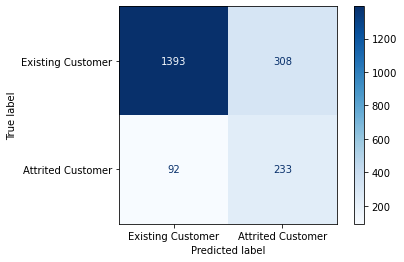

In [9]:
cm = confusion_matrix(y_test, y_pred)
labels = ['Existing Customer', 'Attrited Customer']

diagram = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
diagram.plot(cmap=plt.cm.Blues)
plt.show()